###Financial Fraud Detection using Spark Structured Streaming

In [0]:
#Kaggle link for the datasource - https://www.kaggle.com/ntnu-testimon/paysim1
#Reading the dataset

df = spark.read.csv('dbfs:/FileStore/shared_uploads/kavin.veerapandian@gmail.com/paysim.csv',inferSchema=True,header=True)
df.show(2)

+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
step| type| amount| nameOrig|oldbalanceOrg|newbalanceOrig| nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
 1|PAYMENT|9839.64|C1231006815| 170136.0| 160296.36|M1979787155| 0.0| 0.0| 0| 0|
 1|PAYMENT|1864.28|C1666544295| 21249.0| 19384.72|M2044282225| 0.0| 0.0| 0| 0|
+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
only showing top 2 rows

In [0]:
#Understanding the dataset

#step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

#type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

#amount -amount of the transaction in local currency.

#nameOrig - customer who started the transaction

#oldbalanceOrg - initial balance before the transaction

#newbalanceOrig - new balance after the transaction

#nameDest - customer who is the recipient of the transaction

#oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

#newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

#isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

#isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [0]:
df.printSchema()

root
-- step: integer (nullable = true)
-- type: string (nullable = true)
-- amount: double (nullable = true)
-- nameOrig: string (nullable = true)
-- oldbalanceOrg: double (nullable = true)
-- newbalanceOrig: double (nullable = true)
-- nameDest: string (nullable = true)
-- oldbalanceDest: double (nullable = true)
-- newbalanceDest: double (nullable = true)
-- isFraud: integer (nullable = true)
-- isFlaggedFraud: integer (nullable = true)

In [0]:
display(df)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0
1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0,0
1,PAYMENT,4024.36,C1265012928,2671.0,0.0,M1176932104,0.0,0.0,0,0
1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0


In [0]:
#total number of transactions

df.count()

Out[21]: 6362620

In [0]:
df.createOrReplaceTempView("paysim")

In [0]:
# Checking for null values

from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(d) | col(d).isNull(), d)).alias(d) for d in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+

In [0]:
#different type of payment methods

df.select('type').distinct().show()

+--------+
 type|
+--------+
TRANSFER|
 CASH_IN|
CASH_OUT|
 PAYMENT|
 DEBIT|
+--------+

In [0]:
#The classes are highly imbalanced. There are very few datapoints for fraudulent transactions compared to genuine ones 

df.groupby('isFraud').count().show()

+-------+-------+
isFraud| count|
+-------+-------+
 1| 8213|
 0|6354407|
+-------+-------+

In [0]:
#We can see the average amount for fraudulent and normal transactions. The average amount is much higher compared to normal transactions.

df.groupby('isFraud').mean().show()

+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------+--------------------+
isFraud| avg(step)| avg(amount)|avg(oldbalanceOrg)|avg(newbalanceOrig)|avg(oldbalanceDest)|avg(newbalanceDest)|avg(isFraud)| avg(isFlaggedFraud)|
+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------+--------------------+
 1| 368.4138560818215|1467967.2991403877|1649667.6057116778| 192392.63183611355| 544249.6190746377| 1279707.6171459886| 1.0|0.001948131011810...|
 0|243.23566306029815| 178197.0417274069| 832828.7117272614| 855970.2281088016| 1101420.8745693814| 1224925.6845631644| 0.0| 0.0|
+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------+--------------------+

In [0]:
# Checking the descriptive statistics of all the numeric columns

df.select('amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest').describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+
summary| amount| oldbalanceOrg| newbalanceOrig| oldbalanceDest| newbalanceDest|
+-------+------------------+------------------+-----------------+------------------+------------------+
 count| 6362620| 6362620| 6362620| 6362620| 6362620|
 mean|179861.90354913048| 833883.1040744851|855113.6685785787|1100701.6665196505|1224996.3982019336|
 stddev| 603858.2314629437|2888242.6730375397|2924048.502954241|3399180.1129944543|3674128.9421196654|
 min| 0.0| 0.0| 0.0| 0.0| 0.0|
 max| 9.244551664E7| 5.958504037E7| 4.958504037E7| 3.5601588935E8| 3.5617927892E8|
+-------+------------------+------------------+-----------------+------------------+------------------+

In [0]:
#Converting the spark dataframe to pandas dataframe for creating plots

dfnew = df.toPandas()

In [0]:
dfnew.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

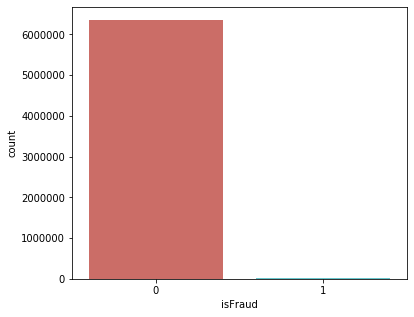

In [0]:
#From the chart, its clear that the data is heavily imbalanced

plt.figure(figsize=(6,5))
sns.countplot(x = "isFraud", data = dfnew, palette="hls")
plt.show()

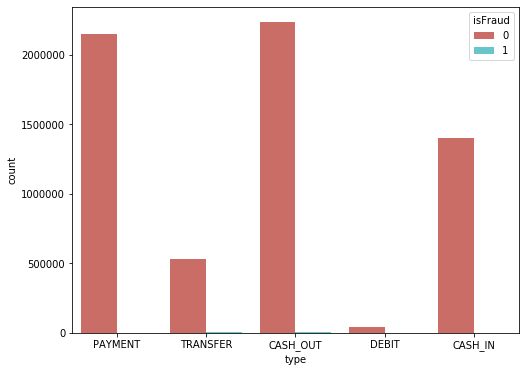

In [0]:
#From this chart, we can see that fraudulent transactions happen most frequently when the type is 'Transfer'
plt.figure(figsize=(8,6))
sns.countplot(x = "type", hue = "isFraud", data = dfnew, palette="hls")
plt.show()

In [0]:
#Checking the Fraudulent Cases for each payment type. From the results we cans see that the fraudulent cases exists only for Cash_out and Trasnfer payment type.

spark.sql("select type, count(isFraud) as FraudCases from paysim where isFraud = 1 group by type order by FraudCases desc").show()

+--------+----------+
 type|FraudCases|
+--------+----------+
CASH_OUT| 4116|
TRANSFER| 4097|
+--------+----------+

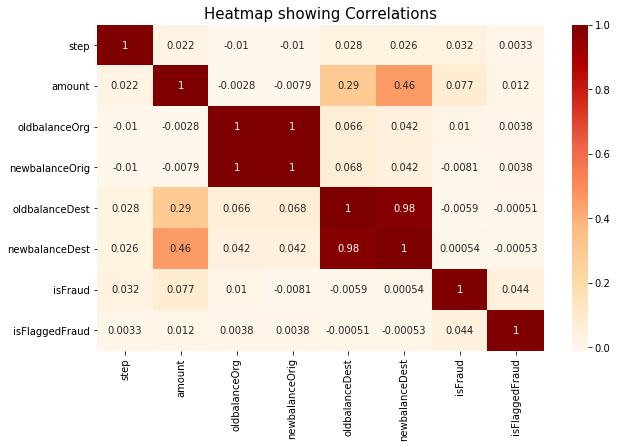

In [0]:
#There is high correlation between the destination account details ie the old and new balance

plt.figure(figsize=(10,6))
sns.heatmap(dfnew.corr(),annot=True, cmap= 'OrRd')
plt.title('Heatmap showing Correlations',size=15)
plt.show()

In [0]:
#Checking the number of Fraudulent Cases for each unit of time.

spark.sql("select step, count(isFraud) as FraudCases from paysim where isFraud = 1 group by step  having FraudCases > 10 order by FraudCases desc").show()

+----+----------+
step|FraudCases|
+----+----------+
 212| 40|
 523| 30|
 425| 28|
 730| 28|
 249| 28|
 387| 28|
 501| 28|
 398| 26|
 160| 26|
 694| 24|
 66| 24|
 625| 24|
 406| 24|
 22| 23|
 296| 22|
 74| 22|
 34| 22|
 279| 22|
 149| 22|
 262| 22|
+----+----------+
only showing top 20 rows

In [0]:
#Using Undersampling to create a Balanced Dataset
 
ones = df.filter(df["isFraud"]==1)
zeros = df.filter(df["isFraud"]==0)
 
dff = (df.count()) * 1.0
onesf = (ones.count()) * 1.0
zerosf = (zeros.count()) * 1.0
 
sampleRatio = onesf/ dff
nonFraudSampleDf = zeros.sample(withReplacement=False, fraction=sampleRatio)
 
dfbalanced = ones.unionAll(nonFraudSampleDf)
dfbalanced.show(5)

+----+--------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
step| type| amount| nameOrig|oldbalanceOrg|newbalanceOrig| nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
 1|TRANSFER| 181.0|C1305486145| 181.0| 0.0| C553264065| 0.0| 0.0| 1| 0|
 1|CASH_OUT| 181.0| C840083671| 181.0| 0.0| C38997010| 21182.0| 0.0| 1| 0|
 1|TRANSFER| 2806.0|C1420196421| 2806.0| 0.0| C972765878| 0.0| 0.0| 1| 0|
 1|CASH_OUT| 2806.0|C2101527076| 2806.0| 0.0|C1007251739| 26202.0| 0.0| 1| 0|
 1|TRANSFER|20128.0| C137533655| 20128.0| 0.0|C1848415041| 0.0| 0.0| 1| 0|
+----+--------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
only showing top 5 rows

In [0]:
#Total number of transactions after undersampling

dfbalanced.count()

Out[72]: 16417

In [0]:
#The sampling technique has picked up more datapoints for transfer and cash out because thats where most of the fraudulent transactions happen

display(dfbalanced.groupby('type').count())

type,count
TRANSFER,4799
CASH_OUT,6960
CASH_IN,1820
PAYMENT,2793
DEBIT,45


In [0]:
#The target variable is now balanced

display(dfbalanced.groupby('isFraud').count())

isFraud,count
1,8213
0,8154


In [0]:
# Importing the necessary libraries for building our models

from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline

In [0]:
#Use StringIndexer to convert the categorical columns to hold numerical data

type_indexer = StringIndexer(inputCol='type',outputCol='type_index',handleInvalid='keep')

In [0]:
#OneHotEncoderEstimator converts the indexed data into a vector which will be effectively handled by the model

data_encoder = OneHotEncoder(inputCols=['type_index'], outputCols=['type_vec'], handleInvalid='keep')

In [0]:
#Vector assembler is used to create a vector of input feature

assembler=VectorAssembler(inputCols=['type_vec','amount','oldbalanceOrg',
                                    'newbalanceOrig','oldbalanceDest'],
                           outputCol="unscaled_features")

In [0]:
#Scaling the data for better performance of the models

scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

In [0]:
#Creating the pipeline

pipe = Pipeline(stages=[type_indexer,data_encoder,assembler,scaler])

In [0]:
#Creating stratified train test split

zeros = dfbalanced.filter(df["isFraud"]==0)
ones = dfbalanced.filter(df["isFraud"]==1)

train0, test0 = zeros.randomSplit([0.8,0.2], seed=1234)
train1, test1 = ones.randomSplit([0.8,0.2], seed=1234)

# stack datasets back together
train_data = train0.union(train1)
test_data = test0.union(test1)

In [0]:
train_data.show(5)

+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
step| type| amount| nameOrig|oldbalanceOrg|newbalanceOrig| nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
 1|CASH_IN|37590.03| C810353241| 2702214.59| 2739804.62| C884457408| 375432.34| 84916.82| 0| 0|
 1|PAYMENT| 3920.09|C1785807415| 21900.0| 17979.91|M1041451158| 0.0| 0.0| 0| 0|
 3|PAYMENT| 4530.34|C1485129132| 0.0| 0.0| M721975085| 0.0| 0.0| 0| 0|
 5|PAYMENT| 1627.82| C215351125| 44167.0| 42539.18|M1610818058| 0.0| 0.0| 0| 0|
 6|PAYMENT| 414.32| C340234965| 0.0| 0.0| M497424937| 0.0| 0.0| 0| 0|
+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
only showing top 5 rows

In [0]:
#Fitting the data on train and transforming it on train & test for preprocessing

pipemodel=pipe.fit(train_data)
train_trans=pipemodel.transform(train_data)
test_trans=pipemodel.transform(test_data)

In [0]:
display(train_trans)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_index,type_vec,unscaled_features,features
1,CASH_IN,37590.03,C810353241,2702214.59,2739804.62,C884457408,375432.34,84916.82,0,0,3.0,"List(0, 6, List(3), List(1.0))","List(0, 10, List(3, 6, 7, 8, 9), List(1.0, 37590.03, 2702214.59, 2739804.62, 375432.34))","List(0, 10, List(3, 6, 7, 8, 9), List(3.1763572045673176, 0.020073626955253412, 0.8249863638312483, 1.0706681044663062, 0.11031006228912145))"
1,PAYMENT,3920.09,C1785807415,21900.0,17979.91,M1041451158,0.0,0.0,0,0,2.0,"List(0, 6, List(2), List(1.0))","List(0, 10, List(2, 6, 7, 8), List(1.0, 3920.09, 21900.0, 17979.91))","List(0, 10, List(2, 6, 7, 8), List(2.655250889295055, 0.0020933855144840093, 0.00668607202209812, 0.007026236840995904))"
3,PAYMENT,4530.34,C1485129132,0.0,0.0,M721975085,0.0,0.0,0,0,2.0,"List(0, 6, List(2), List(1.0))","List(0, 10, List(2, 6), List(1.0, 4530.34))","List(0, 10, List(2, 6), List(2.655250889295055, 0.002419267958564086))"
5,PAYMENT,1627.82,C215351125,44167.0,42539.18,M1610818058,0.0,0.0,0,0,2.0,"List(0, 6, List(2), List(1.0))","List(0, 10, List(2, 6, 7, 8), List(1.0, 1627.82, 44167.0, 42539.18))","List(0, 10, List(2, 6, 7, 8), List(2.655250889295055, 8.692797380129946E-4, 0.01348418917808254, 0.016623573405081346))"
6,PAYMENT,414.32,C340234965,0.0,0.0,M497424937,0.0,0.0,0,0,2.0,"List(0, 6, List(2), List(1.0))","List(0, 10, List(2, 6), List(1.0, 414.32))","List(0, 10, List(2, 6), List(2.655250889295055, 2.212529524477792E-4))"
6,PAYMENT,5644.05,C788684446,356150.0,350505.95,M46719126,0.0,0.0,0,0,2.0,"List(0, 6, List(2), List(1.0))","List(0, 10, List(2, 6, 7, 8), List(1.0, 5644.05, 356150.0, 350505.95))","List(0, 10, List(2, 6, 7, 8), List(2.655250889295055, 0.003014005421565187, 0.10873262788448608, 0.13697164328844072))"
7,CASH_OUT,191484.93,C1732238376,0.0,0.0,C465257140,223361.33,1078685.56,0,0,0.0,"List(0, 6, List(0), List(1.0))","List(0, 10, List(0, 6, 9), List(1.0, 191484.93, 223361.33))","List(0, 10, List(0, 6, 9), List(2.0243938610971597, 0.10225575910348603, 0.06562834258039946))"
7,CASH_OUT,309066.58,C562960526,0.0,0.0,C1838584624,7852593.45,1.188977625E7,0,0,0.0,"List(0, 6, List(0), List(1.0))","List(0, 10, List(0, 6, 9), List(1.0, 309066.58, 7852593.45))","List(0, 10, List(0, 6, 9), List(2.0243938610971597, 0.16504608352948869, 2.307260138006883))"
7,PAYMENT,2990.38,C119418333,20685.0,17694.62,M137463816,0.0,0.0,0,0,2.0,"List(0, 6, List(2), List(1.0))","List(0, 10, List(2, 6, 7, 8), List(1.0, 2990.38, 20685.0, 17694.62))","List(0, 10, List(2, 6, 7, 8), List(2.655250889295055, 0.0015969067482641194, 0.006315132409913223, 0.006914750459341729))"
7,PAYMENT,3445.22,C1842851631,266.0,0.0,M1586219070,0.0,0.0,0,0,2.0,"List(0, 6, List(2), List(1.0))","List(0, 10, List(2, 6, 7), List(1.0, 3445.22, 266.0))","List(0, 10, List(2, 6, 7), List(2.655250889295055, 0.0018397979745900218, 8.120982456064382E-5))"


In [0]:
#Using logistic regression algorithm and training it on the train data

lrmodel = LogisticRegression(labelCol='isFraud')

fit_model_lr = lrmodel.fit(train_trans)

In [0]:
#Using Linear SVC algorithm and training it on the train data

svc_model = LinearSVC(labelCol='isFraud')

fit_model_svc = svc_model.fit(train_trans)

In [0]:
#Using the Decision tree algorithm and training it on the train data

dt_model = DecisionTreeClassifier(labelCol='isFraud',maxBins=5000)

fit_model_dt = dt_model.fit(train_trans)

In [0]:
#Setting the path where our testing data will be residing

testPath = "/FileStore/tables/paysimtesting"

In [0]:
#Splitting the test data into 10 parts and writing it in the testpath as parquet files
#This is done to demonstrate the flow of data in real-time

test_trans.repartition(10).write.mode("overwrite").parquet(testPath)

In [0]:
#reading the schema of our training dataset

dataSchema = train_trans.schema

In [0]:
#creating the stream for test data
#Picking one file per trigger

streaming = spark.readStream.schema(dataSchema).option("maxFilesPerTrigger", 1).parquet(testPath)

In [0]:
#Prediciting for our test data

streamingrate_lr = fit_model_lr.transform(streaming)
streamingrate_svc = fit_model_svc.transform(streaming)
streamingrate_dt = fit_model_dt.transform(streaming)

In [0]:
#importing the necessary evaluators

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix,classification_report

In [0]:
#Evaluation - area under the curve and accuracy

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='isFraud',metricName='areaUnderROC')
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="isFraud", predictionCol="prediction", metricName="accuracy")

In [0]:
#This is a function to evaluate our models

def foreachbatch_function(df, epoch_id):
  AUC = AUC_evaluator.evaluate(df)
  accuracy = ACC_evaluator.evaluate(df)
  print("For test file " + str(epoch_id) +",")
  print("Area under the curve : {}".format(AUC))
  print("Accuracy of the model : {}".format(accuracy))
  
  y_true = df.select("isFraud")
  y_true = y_true.toPandas()
  y_pred = df.select("prediction")
  y_pred = y_pred.toPandas()
  cnf_matrix = confusion_matrix(y_true, y_pred)
  print("Confusion matrix : \n {}".format(cnf_matrix))
  print("\nClassification Report :\n", classification_report(y_true, y_pred))
  
  pass
  

In [0]:
#Streaming the test data transformed with the logistic regression model and evaluating it for each parquet file

test = streamingrate_lr.writeStream.format("console").outputMode("update").foreachBatch(foreachbatch_function).start()

test.awaitTermination()

For test file 0,
Area under the curve : 0.9362342941611234
Accuracy of the model : 0.9361702127659575
Confusion matrix : 
 [[157 7]
 [ 14 151]]

Classification Report :
 precision recall f1-score support

 0 0.92 0.96 0.94 164
 1 0.96 0.92 0.93 165

 accuracy 0.94 329
 macro avg 0.94 0.94 0.94 329
weighted avg 0.94 0.94 0.94 329

For test file 1,
Area under the curve : 0.9451942740286299
Accuracy of the model : 0.9451219512195121
Confusion matrix : 
 [[154 11]
 [ 7 156]]

Classification Report :
 precision recall f1-score support

 0 0.96 0.93 0.94 165
 1 0.93 0.96 0.95 163

 accuracy 0.95 328
 macro avg 0.95 0.95 0.95 328
weighted avg 0.95 0.95 0.95 328

For test file 2,
Area under the curve : 0.9305038335158816
Accuracy of the model : 0.9305135951661632
Confusion matrix : 
 [[155 11]
 [ 12 153]]

Classification Report :
 precision recall f1-score support

 0 0.93 0.93 0.93 166
 1 0.93 0.93 0.93 165

 accuracy 0.93 331
 macro avg 0.93 0.93 0.93 331
weighted avg 0.93 0.93 0.93 331

For test file 3,
Area under the curve : 0.9154781346398113
Accuracy of the model : 0.9156626506024096
Confusion matrix : 
 [[158 9]
 [ 19 146]]

Classification Report :
 precision recall f1-score support

 0 0.89 0.95 0.92 167
 1 0.94 0.88 0.91 165

 accuracy 0.92 332
 macro avg 0.92 0.92 0.92 332
weighted avg 0.92 0.92 0.92 332

For test file 4,
Area under the curve : 0.9277082199237888
Accuracy of the model : 0.927710843373494
Confusion matrix : 
 [[155 12]
 [ 12 153]]

Classification Report :
 precision recall f1-score support

 0 0.93 0.93 0.93 167
 1 0.93 0.93 0.93 165

 accuracy 0.93 332
 macro avg 0.93 0.93 0.93 332
weighted avg 0.93 0.93 0.93 332

For test file 5,
Area under the curve : 0.9271598589479871
Accuracy of the model : 0.9272727272727272
Confusion matrix : 
 [[157 9]
 [ 15 149]]

Classification Report :
 precision recall f1-score support

 0 0.91 0.95 0.93 166
 1 0.94 0.91 0.93 164

 accuracy 0.93 330
 macro avg 0.93 0.93 0.93 330
weighted avg 0.93 0.93 0.93 330

For test file 6,
Area under the curve : 0.9484848484848485
Accuracy of the model : 0.9484848484848485
Confusion matrix : 
 [[155 10]
 [ 7 158]]

Classification Report :
 precision recall f1-score support

 0 0.96 0.94 0.95 165
 1 0.94 0.96 0.95 165

 accuracy 0.95 330
 macro avg 0.95 0.95 0.95 330
weighted avg 0.95 0.95 0.95 330

For test file 7,
Area under the curve : 0.9634132738427217
Accuracy of the model : 0.9634146341463414
Confusion matrix : 
 [[159 6]
 [ 6 157]]

Classification Report :
 precision recall f1-score support

 0 0.96 0.96 0.96 165
 1 0.96 0.96 0.96 163

 accuracy 0.96 328
 macro avg 0.96 0.96 0.96 328
weighted avg 0.96 0.96 0.96 328

For test file 8,
Area under the curve : 0.918270643549809
Accuracy of the model : 0.9181818181818182
Confusion matrix : 
 [[150 16]
 [ 11 153]]

Classification Report :
 precision recall f1-score support

 0 0.93 0.90 0.92 166
 1 0.91 0.93 0.92 164

 accuracy 0.92 330
 macro avg 0.92 0.92 0.92 330
weighted avg 0.92 0.92 0.92 330

For test file 9,
Area under the curve : 0.9517691888949373
Accuracy of the model : 0.9518072289156626
Confusion matrix : 
 [[160 7]
 [ 9 156]]

Classification Report :
 precision recall f1-score support

 0 0.95 0.96 0.95 167
 1 0.96 0.95 0.95 165

 accuracy 0.95 332
 macro avg 0.95 0.95 0.95 332
weighted avg 0.95 0.95 0.95 332

In [0]:
#Streaming the test data transformed with the linearSVC model and evaluating it for each parquet file

test = streamingrate_svc.writeStream.format("console").outputMode("update").foreachBatch(foreachbatch_function).start()

test.awaitTermination()

For test file 0,
Area under the curve : 0.9422949002217295
Accuracy of the model : 0.9422492401215805
Confusion matrix : 
 [[157 7]
 [ 12 153]]

Classification Report :
 precision recall f1-score support

 0 0.93 0.96 0.94 164
 1 0.96 0.93 0.94 165

 accuracy 0.94 329
 macro avg 0.94 0.94 0.94 329
weighted avg 0.94 0.94 0.94 329

For test file 1,
Area under the curve : 0.9452314556609035
Accuracy of the model : 0.9451219512195121
Confusion matrix : 
 [[153 12]
 [ 6 157]]

Classification Report :
 precision recall f1-score support

 0 0.96 0.93 0.94 165
 1 0.93 0.96 0.95 163

 accuracy 0.95 328
 macro avg 0.95 0.95 0.95 328
weighted avg 0.95 0.95 0.95 328

For test file 2,
Area under the curve : 0.9305038335158816
Accuracy of the model : 0.9305135951661632
Confusion matrix : 
 [[155 11]
 [ 12 153]]

Classification Report :
 precision recall f1-score support

 0 0.93 0.93 0.93 166
 1 0.93 0.93 0.93 165

 accuracy 0.93 331
 macro avg 0.93 0.93 0.93 331
weighted avg 0.93 0.93 0.93 331

For test file 3,
Area under the curve : 0.9336236617673742
Accuracy of the model : 0.9337349397590361
Confusion matrix : 
 [[159 8]
 [ 14 151]]

Classification Report :
 precision recall f1-score support

 0 0.92 0.95 0.94 167
 1 0.95 0.92 0.93 165

 accuracy 0.93 332
 macro avg 0.93 0.93 0.93 332
weighted avg 0.93 0.93 0.93 332

For test file 4,
Area under the curve : 0.9397205588822356
Accuracy of the model : 0.9397590361445783
Confusion matrix : 
 [[158 9]
 [ 11 154]]

Classification Report :
 precision recall f1-score support

 0 0.93 0.95 0.94 167
 1 0.94 0.93 0.94 165

 accuracy 0.94 332
 macro avg 0.94 0.94 0.94 332
weighted avg 0.94 0.94 0.94 332

For test file 5,
Area under the curve : 0.9302086394357919
Accuracy of the model : 0.9303030303030303
Confusion matrix : 
 [[157 9]
 [ 14 150]]

Classification Report :
 precision recall f1-score support

 0 0.92 0.95 0.93 166
 1 0.94 0.91 0.93 164

 accuracy 0.93 330
 macro avg 0.93 0.93 0.93 330
weighted avg 0.93 0.93 0.93 330

For test file 6,
Area under the curve : 0.9454545454545454
Accuracy of the model : 0.9454545454545454
Confusion matrix : 
 [[154 11]
 [ 7 158]]

Classification Report :
 precision recall f1-score support

 0 0.96 0.93 0.94 165
 1 0.93 0.96 0.95 165

 accuracy 0.95 330
 macro avg 0.95 0.95 0.95 330
weighted avg 0.95 0.95 0.95 330

For test file 7,
Area under the curve : 0.9634132738427217
Accuracy of the model : 0.9634146341463414
Confusion matrix : 
 [[159 6]
 [ 6 157]]

Classification Report :
 precision recall f1-score support

 0 0.96 0.96 0.96 165
 1 0.96 0.96 0.96 163

 accuracy 0.96 328
 macro avg 0.96 0.96 0.96 328
weighted avg 0.96 0.96 0.96 328

For test file 8,
Area under the curve : 0.9213194240376139
Accuracy of the model : 0.9212121212121213
Confusion matrix : 
 [[150 16]
 [ 10 154]]

Classification Report :
 precision recall f1-score support

 0 0.94 0.90 0.92 166
 1 0.91 0.94 0.92 164

 accuracy 0.92 330
 macro avg 0.92 0.92 0.92 330
weighted avg 0.92 0.92 0.92 330

For test file 9,
Area under the curve : 0.9518054799491925
Accuracy of the model : 0.9518072289156626
Confusion matrix : 
 [[159 8]
 [ 8 157]]

Classification Report :
 precision recall f1-score support

 0 0.95 0.95 0.95 167
 1 0.95 0.95 0.95 165

 accuracy 0.95 332
 macro avg 0.95 0.95 0.95 332
weighted avg 0.95 0.95 0.95 332

In [0]:
#Streaming the test data transformed with the decision tree model and evaluating it for each parquet file

test = streamingrate_dt.writeStream.format("console").outputMode("update").foreachBatch(foreachbatch_function).start()

test.awaitTermination()

For test file 0,
Area under the curve : 0.9939024390243902
Accuracy of the model : 0.993920972644377
Confusion matrix : 
 [[162 2]
 [ 0 165]]

Classification Report :
 precision recall f1-score support

 0 1.00 0.99 0.99 164
 1 0.99 1.00 0.99 165

 accuracy 0.99 329
 macro avg 0.99 0.99 0.99 329
weighted avg 0.99 0.99 0.99 329

For test file 1,
Area under the curve : 0.9939022123071203
Accuracy of the model : 0.9939024390243902
Confusion matrix : 
 [[164 1]
 [ 1 162]]

Classification Report :
 precision recall f1-score support

 0 0.99 0.99 0.99 165
 1 0.99 0.99 0.99 163

 accuracy 0.99 328
 macro avg 0.99 0.99 0.99 328
weighted avg 0.99 0.99 0.99 328

For test file 2,
Area under the curve : 0.9788974078130704
Accuracy of the model : 0.9788519637462235
Confusion matrix : 
 [[160 6]
 [ 1 164]]

Classification Report :
 precision recall f1-score support

 0 0.99 0.96 0.98 166
 1 0.96 0.99 0.98 165

 accuracy 0.98 331
 macro avg 0.98 0.98 0.98 331
weighted avg 0.98 0.98 0.98 331

For test file 3,
Area under the curve : 0.993975684993649
Accuracy of the model : 0.9939759036144579
Confusion matrix : 
 [[166 1]
 [ 1 164]]

Classification Report :
 precision recall f1-score support

 0 0.99 0.99 0.99 167
 1 0.99 0.99 0.99 165

 accuracy 0.99 332
 macro avg 0.99 0.99 0.99 332
weighted avg 0.99 0.99 0.99 332

For test file 4,
Area under the curve : 0.9759390310288514
Accuracy of the model : 0.9759036144578314
Confusion matrix : 
 [[162 5]
 [ 3 162]]

Classification Report :
 precision recall f1-score support

 0 0.98 0.97 0.98 167
 1 0.97 0.98 0.98 165

 accuracy 0.98 332
 macro avg 0.98 0.98 0.98 332
weighted avg 0.98 0.98 0.98 332

For test file 5,
Area under the curve : 0.9878783426388481
Accuracy of the model : 0.9878787878787879
Confusion matrix : 
 [[164 2]
 [ 2 162]]

Classification Report :
 precision recall f1-score support

 0 0.99 0.99 0.99 166
 1 0.99 0.99 0.99 164

 accuracy 0.99 330
 macro avg 0.99 0.99 0.99 330
weighted avg 0.99 0.99 0.99 330

For test file 6,
Area under the curve : 0.9848484848484848
Accuracy of the model : 0.9848484848484849
Confusion matrix : 
 [[161 4]
 [ 1 164]]

Classification Report :
 precision recall f1-score support

 0 0.99 0.98 0.98 165
 1 0.98 0.99 0.98 165

 accuracy 0.98 330
 macro avg 0.99 0.98 0.98 330
weighted avg 0.99 0.98 0.98 330

For test file 7,
Area under the curve : 0.993939393939394
Accuracy of the model : 0.9939024390243902
Confusion matrix : 
 [[163 2]
 [ 0 163]]

Classification Report :
 precision recall f1-score support

 0 1.00 0.99 0.99 165
 1 0.99 1.00 0.99 163

 accuracy 0.99 328
 macro avg 0.99 0.99 0.99 328
weighted avg 0.99 0.99 0.99 328

For test file 8,
Area under the curve : 0.9788789303555686
Accuracy of the model : 0.9787878787878788
Confusion matrix : 
 [[160 6]
 [ 1 163]]

Classification Report :
 precision recall f1-score support

 0 0.99 0.96 0.98 166
 1 0.96 0.99 0.98 164

 accuracy 0.98 330
 macro avg 0.98 0.98 0.98 330
weighted avg 0.98 0.98 0.98 330

For test file 9,
Area under the curve : 0.9879876610415532
Accuracy of the model : 0.9879518072289156
Confusion matrix : 
 [[164 3]
 [ 1 164]]

Classification Report :
 precision recall f1-score support

 0 0.99 0.98 0.99 167
 1 0.98 0.99 0.99 165

 accuracy 0.99 332
 macro avg 0.99 0.99 0.99 332
weighted avg 0.99 0.99 0.99 332

#### We are using structured streaming on our test data, hence we see that our test files are being evaluated one by one for all three models. Linear SVM and logistic regression models seem to be giving almost similar results. Decision tree performs much better compared to the other models in terms of accuracy, f1 score etc. The decision tree model consistenly predicts with an accuracy of around 98% and f1-score of about 98% on average across all the files.  
 #### In our problem,the cost for failing to identify fraudulent data is very high. In such cases, we have to look at the false negative rate. From the confusion matrix generated for the predictions made by each model, the decision tree model by far did the best in reducing the false positives. It incorrectly classifies just 1 or 2 fraudulent transactions as genuine ones.

#### Our dataset was heavily imbalanced. There were very few datapoints on fraudent transactions compared to genuine ones. When we ran our models with the imbalanced dataset, we were getting faulty results. The models was incorrectly classifying the fraudulent transactions. From the confusion matrix, we were able to see that the false positives were high for this dataset. To overcome this, we balanced the dataset using an undersampling technique. This made a difference in our model evaluation results. The models got good at predicting the fraudulent transactions.

#### Another challenge we faced because of the limitations in the community edition. When we were splitting the testing data initially, there was a lot of metadata getting written into the DBFS system. The community edition has a limit on the number of files that could be written in the DBFS system. To overcome this, we had to remove all the meta data that were getting written. An alternation solution would have been to configure the clusters to not generate the meta data. This was not possibe, since we were using community edition.